# 16S rRNA amplicon analysis of the Finnish children

```sh
# Extract file URL
wget -q -O - https://diabimmune.broadinstitute.org/diabimmune/data/9/ | grep -oP "(?<=href=')[^']*.fastq.gz" > ../../data/2024-05-02/file_list.txt
# Download fastq files
wget --no-check-certificate -P ../../data/2024-05-02/hmp2_fastq --input-file=../../data/2024-05-02/file_list.txt --output-file=../../data/2024-05-02/wget_logfile --wait=10
# Import
ls ../../data/2024-05-02/hmp2_fastq/ | awk -F'_' -v P="$(readlink -f ../../data/2024-05-02/hmp2_fastq)" 'BEGIN { print "sample-id,absolute-filepath,direction" } { if ( NR%2==0 ) { print $1","P"/"$0",reverse" } else { print $1","P"/"$0",forward"} }' > ../../data/2024-05-02/Manifest.csv
qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path ../../data/2024-05-02/Manifest.csv --output-path ../../data/2024-05-02/demux.qza --input-format PairedEndFastqManifestPhred33
# Visualize
qiime demux summarize --i-data ../../data/2024-05-02/demux.qza --o-visualization ../../data/2024-05-02/demux.qzv
# DADA2
qiime dada2 denoise-paired --i-demultiplexed-seqs ../../data/2024-05-02/demux.qza --p-trunc-len-f 0 --p-trunc-len-r 160 --p-n-threads 4 --o-table ../../data/2024-05-02/table.qza --o-denoising-stats ../../data/2024-05-02/stats.qza --o-representative-sequences ../../data/2024-05-02/rep-seqs.qza --verbose
# Got DaDa2 error
```

In [76]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

matplotlib.rcParams['font.family']       = 'Arial'
matplotlib.rcParams['font.sans-serif']   = ["Arial","DejaVu Sans","Lucida Grande","Verdana"]
matplotlib.rcParams["figure.figsize"]    = [4,3]
matplotlib.rcParams["font.size"]         = 10
matplotlib.rcParams["axes.labelcolor"]   = "#000000"
matplotlib.rcParams["axes.linewidth"]    = 1.0
matplotlib.rcParams["xtick.major.width"] = 1.0
matplotlib.rcParams["ytick.major.width"] = 1.0
cmap1 = plt.cm.tab20
cmap2 = plt.cm.Set3

from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
# Per sample read
read_cnt = pd.read_csv("../../data/2024-05-02/per-sample-fastq-counts.tsv", sep="\t")
# Remove errorous pair-end samples
read_cnt["is_equal"] = read_cnt.apply(lambda df: df["forward sequence count"] == df["reverse sequence count"], axis=1)
read_cnt_equal = read_cnt[read_cnt["is_equal"]].copy()
# Metadata
metadata = pd.read_csv("../../data/2024-05-02/diabimmune_t1d_16s_metadata.csv")
metadata.head()
# Merge
metadata_study_sample = pd.merge(metadata, read_cnt_equal, how="inner", left_on="G_id", right_on="sample ID")
metadata_study_sample.to_csv("../../data/2024-05-02/metadata_study_sample.tsv", sep="\t", index=False)

# Make Manifest file for QIIME2
manifest = pd.read_csv("../../data/2024-05-02/Manifest.csv")
set_study_sample = set(list(metadata_study_sample["G_id"]))
manifest_stydy_sample = manifest[manifest["sample-id"].apply(lambda x: x in set_study_sample)].copy()
manifest_stydy_sample.to_csv("../../data/2024-05-02/Manifest_study_sample.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/2024-05-02/per-sample-fastq-counts.tsv'

```sh
# Import
qiime tools import --type 'SampleData[PairedEndSequencesWithQuality]' --input-path ../../data/2024-05-02/Manifest_study_sample.csv --output-path ../../data/2024-05-02/demux_study_sample.qza --input-format PairedEndFastqManifestPhred33
qiime demux summarize --i-data ../../data/2024-05-02/demux_study_sample.qza --o-visualization ../../data/2024-05-02/demux_study_sample.qzv
# DADA2
qiime dada2 denoise-paired --i-demultiplexed-seqs ../../data/2024-05-02/demux_study_sample.qza --p-trunc-len-f 0 --p-trunc-len-r 160 --p-n-threads 4 --o-table ../../data/2024-05-02/table_study_sample.qza --o-denoising-stats ../../data/2024-05-02/stats_study_sample.qza --o-representative-sequences ../../data/2024-05-02/reps_sequences_study_sample.qza --verbose
# Export
qiime tools export --input-path ../../data/2024-05-02/reps_sequences_study_sample.qza --output-path ../../data/2024-05-02/
qiime tools export --input-path ../../data/2024-05-02/table_study_sample.qza --output-path ../../data/2024-05-02/
biom convert -i ../../data/2024-05-02/feature-table.biom -o ../../data/2024-05-02/feature_table_study_sample.tsv --to-tsv
```

```sh
bac_to_feature.py -s ../../data/2024-06-16/dna-sequences.fasta -o ../../data/2024-06-16/predicted_trait.tsv -m picrust --ref_dir ../../data/2024-06-06/b2f_ref --ref_table ../../data/2024-06-06/binarized_traits.tsv --intermediate_dir ../../data/2024-06-16/intermediate_dir --threads 20 --calculate_NSTI
```

```sh
# Classifying taxonomy
qiime feature-classifier classify-sklearn --i-classifier ../../data/2023-09-04/silva-138-99-nb-classifier.qza --i-reads ../../data/2024-06-16/reps_sequences_study_sample.qza --o-classification ../../data/2024-06-16/taxonomy_study_sample.qza
# Barplot
qiime taxa barplot --i-table ../../data/2024-06-16/table_study_sample.qza --i-taxonomy ../../data/2024-06-16/taxonomy_study_sample.qza --m-metadata-file ../../data/2024-06-16/qiime_metadata.tsv --o-visualization ../../data/2024-06-16/taxa_barplot.qzv
```

In [2]:
predicted_trait_path = "../../data/2024-06-16/predicted_trait.tsv"
pred = pd.read_csv(predicted_trait_path, sep="\t")

threshold_phylodistance = pd.read_csv("../../data/2024-06-14/threshold_phylodistance.tsv", sep= "\t", index_col=0)

## Taxonomic compositions

### Phylum level

In [7]:
taxa = pd.read_csv('../../data/2024-06-16/level-7.csv', sep=',')

# Normarize
taxa_cols = [c for c in taxa.columns if 'd__' in c]
taxa[taxa_cols] = taxa[taxa_cols] / taxa[taxa_cols].sum(axis=1)[:,None]

# Melt
taxa_melt = taxa.melt(id_vars=['index'], value_vars=taxa_cols, var_name='taxa', value_name='abundance')

# Split taxonomy columns
taxa_split = taxa_melt['taxa'].str.split(';', expand=True)
taxa_split = taxa_split.set_axis(['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
                                  axis=1, copy=False)

taxa_melt_split = pd.concat([taxa_melt, taxa_split], axis=1)

# Top major phylum
phy_sum = taxa_melt_split[['phylum', 'abundance']].groupby('phylum').sum()
phy_sum = phy_sum.reset_index().sort_values(by='abundance', ascending=False)
top_phy = list(phy_sum['phylum'].head(4))

taxa_melt_split['major_phylum'] = taxa_melt_split['phylum'].apply(lambda x: x if x in top_phy else 'others')

# Groupby with Phylum
groupby = taxa_melt_split.groupby(['index', 'major_phylum']).sum()
groupby.reset_index(inplace=True)
groupby.sort_values(by='index').reset_index(inplace=True)

groupby_age = pd.merge(groupby, taxa[['index', 'Age_at_Collection']], how='left', on='index')
groupby_age.sort_values(by=['Age_at_Collection', 'index'], inplace=True)
groupby_age.reset_index(inplace=True, drop=True)

# Binning the age at collection
min_age = groupby_age['Age_at_Collection'].min()
max_age = groupby_age['Age_at_Collection'].max()
groupby_age['age_category'] = pd.cut(groupby_age['Age_at_Collection'],
                                     [min_age, 200, 400, 600, 800, max_age+1], right=False)

bin_width=100
bin_max = 1200
bin_list = list(np.arange(start=0, stop=bin_max+1, step=bin_width))
bin_mid_list = list(np.arange(start=bin_width/2, stop=bin_max+1, step=bin_width))
groupby_age['cut'] = pd.cut(groupby_age['Age_at_Collection'], bins=bin_list)

/tmp/ipykernel_2937982/3006093437.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  taxa[taxa_cols] = taxa[taxa_cols] / taxa[taxa_cols].sum(axis=1)[:,None]
/tmp/ipykernel_2937982/3006093437.py:25: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby = taxa_melt_split.groupby(['index', 'major_phylum']).sum()


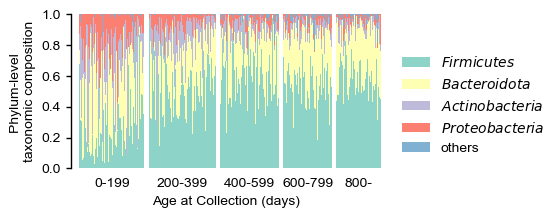

In [8]:
import matplotlib as mpl
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

# Visualize
category = list(groupby_age['age_category'].unique())
nsample = [len(groupby_age[groupby_age['age_category']==c]['index'].unique()) for c in category]
[np.arange(i) for i in nsample]

# xaxis
xs = []
s = 20
for i, n in enumerate(nsample):
    xs += [np.arange(s, s + n)]
    s += n + 10

fig, ax = plt.subplots(figsize=(4, 2))

for x, c in zip(xs, category):
    groupby_age_cat = groupby_age[groupby_age['age_category']==c]
    for i, p in enumerate(top_phy+['others']):
        abd = np.array(groupby_age_cat[groupby_age_cat['major_phylum']==p]['abundance'])
        if i == 0:
            ax.bar(x, abd, width=1, color=cmap2.colors[i])
            sum = abd
        else:
            ax.bar(x, abd, bottom=sum, width=1, color=cmap2.colors[i])
            sum += abd

ax.set_xlim(0, xs[-1][-1])
ax.set_ylim(0, 1)
ax.set_xticks([x.mean() for x in xs])
ax.set_xticklabels(['0-199', '200-399', '400-599', '600-799', '800-'])
ax.tick_params(bottom=False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xlabel('Age at Collection (days)')
ax.set_ylabel('Phylum-level \ntaxonomic composition')

ax.legend(['$\it{Firmicutes}$', '$\it{Bacteroidota}$', '$\it{Actinobacteria}$', '$\it{Proteobacteria}$', 'others'], bbox_to_anchor=(1.05, 0.05), loc='lower left', borderaxespad=0, frameon=False)

plt.savefig("../../data/2024-06-16/taxonomy_barplot_finnish_children.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

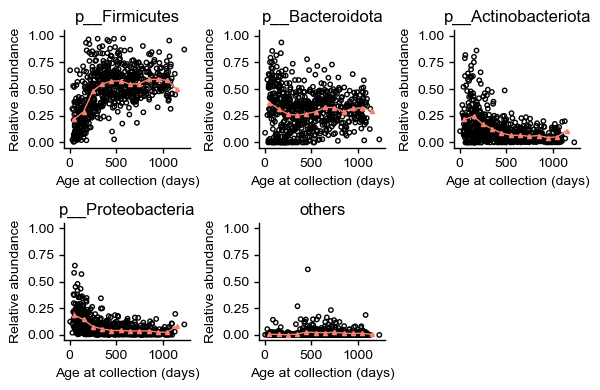

In [9]:
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

fig, axes = plt.subplots(2, 3, figsize=(6, 4))

for p, ax in zip(top_phy + ['others'], axes.flatten()):

    tmp = groupby_age[groupby_age['major_phylum']==p]
    x = tmp['Age_at_Collection']
    y = tmp['abundance']

    ax.scatter(x, y, facecolor="None", edgecolors="black", s=10)
    ax.set_yticks([0.00, 0.25, 0.50, 0.75, 1.0])
    ax.set_xlabel('Age at collection (days)')
    ax.set_ylabel('Relative abundance')
    ax.set_title(p)
    # ax.set_xlim(-1, x.max()+1)
    ax.set_ylim(-0.05, 1.05)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmean = bin_mid_list
    ymean = tmp[['cut', 'abundance']].groupby(by='cut').mean()
    ax.plot(xmean, ymean, marker='^', linewidth=1, markersize=3, color=cmap2.colors[3])

axes.flatten()[-1].set_axis_off()
plt.tight_layout()

plt.savefig("../../data/2024-06-16/rel_abd_phylum.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

### Family level

In [32]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

In [62]:
groupby_family = taxa_melt_split[['index', 'family', 'abundance']].groupby(['index', 'family']).sum()
groupby_family.reset_index(inplace=True)

gb_family_age = pd.merge(groupby_family, taxa[['index', 'Age_at_Collection']], how='inner', on='index')

list_family = list(gb_family_age['family'].unique())

list_r, list_pvalue = [], []
for f in list_family:
    abd = gb_family_age[gb_family_age['family']==f]['abundance']
    age = gb_family_age[gb_family_age['family']==f]['Age_at_Collection']
    r, pvalue = pearsonr(abd, age)
    list_r += [r]
    list_pvalue += [pvalue]
# print(list_pvalue)

res_mptest = multipletests(pvals=list_pvalue, alpha=0.01, method="fdr_bh")
plus_sgn_family = [list_family[i] for i, r in enumerate(res_mptest[0]) if r and list_r[i] > 0]
minus_sgn_family = [list_family[i] for i, r in enumerate(res_mptest[0]) if r and list_r[i] < 0]

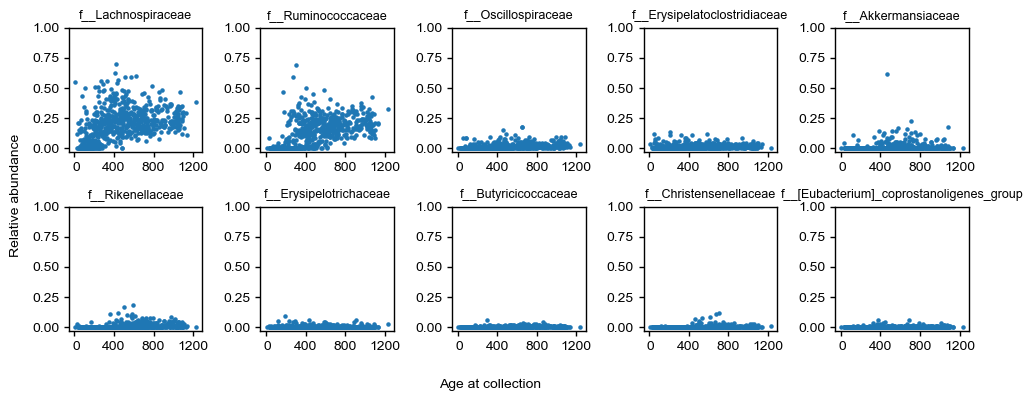

In [96]:
topn = 10

family_sum = groupby_family[['family', 'abundance']].groupby('family').sum()
family_sum.reset_index(inplace=True)

flg_sgn_family = family_sum['family'].apply(lambda x: x in set(plus_sgn_family))
x = family_sum[flg_sgn_family].sort_values(by='abundance', ascending=False).head(topn)
lf_plus = list(x['family'])
# family_sum.sort_values(by='abundance', ascending=False).head(20)

nspecies = len(lf_plus)
ncols = 5
nrows = math.ceil(float(nspecies) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

for f, ax in zip(lf_plus, axes.flatten()):
    abd = gb_family_age[gb_family_age['family']==f]['abundance']
    age = gb_family_age[gb_family_age['family']==f]['Age_at_Collection']
    ax.scatter(age, abd, s=5)
    ax.set_ylim(-0.03, 1)
    ax.set_title(f, fontsize=9)
    ax.xaxis.set_major_locator(MultipleLocator(400))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.supxlabel('Age at collection', fontsize=10)
fig.supylabel('Relative abundance', fontsize=10)

plt.tight_layout()
plt.savefig("../../data/2024-06-16/rel_abd_family_plus.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

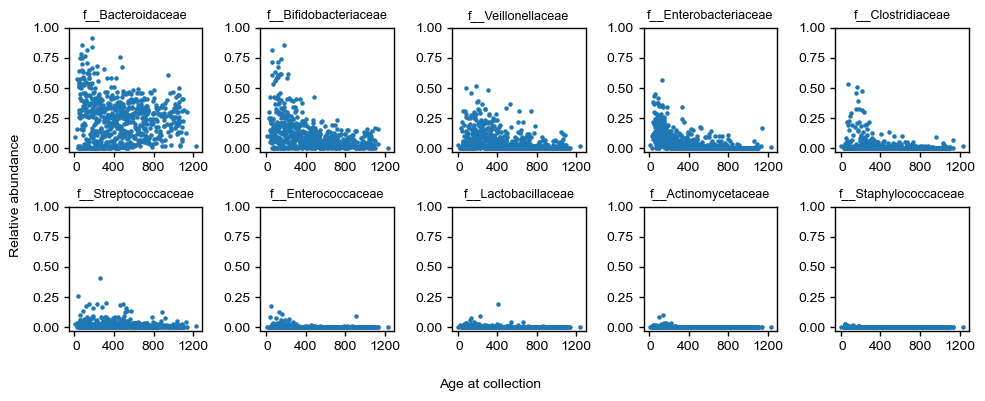

In [97]:
topn = 10

family_sum = groupby_family[['family', 'abundance']].groupby('family').sum()
family_sum.reset_index(inplace=True)

flg_sgn_family = family_sum['family'].apply(lambda x: x in set(minus_sgn_family))
x = family_sum[flg_sgn_family].sort_values(by='abundance', ascending=False).head(topn)
lf_minus = list(x['family'])
# family_sum.sort_values(by='abundance', ascending=False).head(20)

nspecies = len(lf_minus)
ncols = 5
nrows = math.ceil(float(nspecies) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2*ncols, 2*nrows))

for f, ax in zip(lf_minus, axes.flatten()):
    abd = gb_family_age[gb_family_age['family']==f]['abundance']
    age = gb_family_age[gb_family_age['family']==f]['Age_at_Collection']
    ax.scatter(age, abd, s=5)
    ax.set_ylim(-0.03, 1)
    ax.set_title(f, fontsize=9)
    ax.xaxis.set_major_locator(MultipleLocator(400))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%2d'))
    ax.yaxis.set_major_locator(MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.supxlabel('Age at collection', fontsize=10)
fig.supylabel('Relative abundance', fontsize=10)

plt.tight_layout()
plt.savefig("../../data/2024-06-16/rel_abd_family_minus.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

In [98]:
x = {'family': lf_plus + lf_minus, 'sgn': ['+']*len(lf_plus) + ['-']*len(lf_plus)}
df = pd.DataFrame(data=x)

df.to_csv('../../data/2024-06-16/sgn_family.tsv', sep='\t', index=False)

# Trait compositions

In [88]:
# Feature table
table = pd.read_csv("../../data/2024-06-16/feature_table_study_sample.tsv", sep="\t", header=1)
# rename the first column
table.rename(columns={"#OTU ID": "sequence"}, inplace=True)
# # normalize
# abundance = table.iloc[:, 1:]

In [89]:
t = "genome_size"
x = pd.merge(table, pred[["sequence", t+"_nsti"]], how="inner", on="sequence")
filtered_table = x[x[t+"_nsti"] < threshold_phylodistance.loc[t, "threshold"]].drop(t+"_nsti", axis=1).copy()

# normalize
abundance = filtered_table.iloc[:, 1:]
filtered_table.iloc[:, 1:] = abundance / abundance.sum(axis=0)
# melt table
melt_table = filtered_table.melt(id_vars="sequence", value_name="abundance", var_name="sample")
# Merging tooks several seconds
melt_trait = pd.merge(melt_table, pred[["sequence", t]], how="inner", on="sequence")
# Metadata from the paper
metadata = pd.read_csv("../../data/2024-06-16/metadata_study_sample.tsv", sep="\t", dtype=str)
# metadata = sra
# metadata = sra[sra["Assay Type"] == "AMPLICON"].drop_duplicates(subset="host_subject_id", keep="first")

In [90]:
taxonomy = pd.read_csv('../../data/2024-06-16/taxonomy.tsv', sep='\t')
# Split taxonomy columns
taxonomy_split = taxonomy['Taxon'].str.split(';', expand=True)
taxonomy_split = taxonomy_split.set_axis(['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species'],
                                         axis=1, copy=False)

taxonomy_split = pd.concat([taxonomy['Feature ID'], taxonomy_split], axis=1)
# rename the first column
taxonomy_split.rename(columns={"Feature ID": "sequence"}, inplace=True)

In [91]:
def normalize_by_phylum(table, taxonomy_split, p=None):
    abd_cols = table.columns[1:]
    table_tax = pd.merge(table, taxonomy_split, how='inner', on='sequence')
    if p is not None:
        table_tax = table_tax[table_tax['phylum']==p]
    table_tax.reset_index(drop=True, inplace=True)
    table_tax[abd_cols] = table_tax[abd_cols] / table_tax[abd_cols].sum(axis=0)
    return table_tax[table.columns]

In [92]:
titles = {'cell_diameter': 'Cell diameter', 'cell_length': 'Cell length', 'doubling_h': 'Doubling time', 'growth_tmp': 'Growth temp.', 'optimum_tmp': 'Optimum temp.', 'optimum_ph': 'Optimum pH', 'genome_size': 'Genome size', 'gc_content': 'GC content', 'coding_genes': 'Coding genes', 'rRNA16S_genes': 'rRNA16S genes', 'tRNA_genes': 'tRNA genes', 'gram_stain': 'Gram stain', 'sporulation': 'Sporulation', 'motility': 'Motility', 'range_salinity': 'Halophiles', 'facultative_respiration': 'Facultatives', 'anaerobic_respiration': 'Anaerobes', 'aerobic_respiration':'Aerobes' ,'mesophilic_range_tmp': 'Mesophiles', 'thermophilic_range_tmp':'Thermophiles', 'psychrophilic_range_tmp': 'Psychrophiles', 'bacillus_cell_shape': 'Bacillus', 'coccus_cell_shape': 'Coccus', 'filament_cell_shape': 'Filament', 'coccobacillus_cell_shape': 'Coccobacillus', 'vibrio_cell_shape': 'Vibrio', 'spiral_cell_shape': 'Spiral'}

## Continuous traits

### All of microbiome

In [93]:
nt = ["doubling_h", "genome_size", "gc_content", "coding_genes", "optimum_tmp", "growth_tmp", "rRNA16S_genes", "tRNA_genes"]

weighted_nt = dict()
is_first = True

# p = ' p__Bacteroidota'
p = None

for t in nt:
    # filtering
    x = pd.merge(table, pred[["sequence", t+"_nsti"]], how="inner", on="sequence")
    filtered_table = x[x[t+"_nsti"] < threshold_phylodistance.loc[t, "threshold"]].drop(t+"_nsti", axis=1).copy()

    # normalize
    filtered_table = normalize_by_phylum(filtered_table, taxonomy_split, p)
    # melt table
    melt_table = filtered_table.melt(id_vars="sequence", value_name="abundance", var_name="sample")
    # Merging tooks several seconds
    melt_trait = pd.merge(melt_table, pred[["sequence", t]], how="inner", on="sequence")
    melt_trait["weighted_nt"] = melt_trait["abundance"] * melt_trait[t]

    cwm_nt = melt_trait[["sample", "weighted_nt"]].groupby(by="sample").sum()
    cwm_nt = cwm_nt.reset_index()
    cwm_nt = cwm_nt.sort_values(by="sample")

    if len(list(cwm_nt["weighted_nt"])) == 0:
        continue
    if is_first:
        is_first = False
        weighted_nt["sample"] = list(cwm_nt["sample"])
    weighted_nt[t] = list(cwm_nt["weighted_nt"])

cwn_nt_concat = pd.DataFrame(weighted_nt)
cwm_nt_metadata = pd.merge(cwn_nt_concat, metadata, how="inner", left_on="sample", right_on="G_id")

cwm_nt_metadata["Age_at_Collection"] = cwm_nt_metadata["Age_at_Collection"].astype(int)

bin_width=100
bin_max = 1200
bin_list = list(np.arange(start=0, stop=bin_max+1, step=bin_width))
bin_mid_list = list(np.arange(start=bin_width/2, stop=bin_max+1, step=bin_width))
cwm_nt_metadata['cut'] = pd.cut(cwm_nt_metadata['Age_at_Collection'], bins=bin_list)

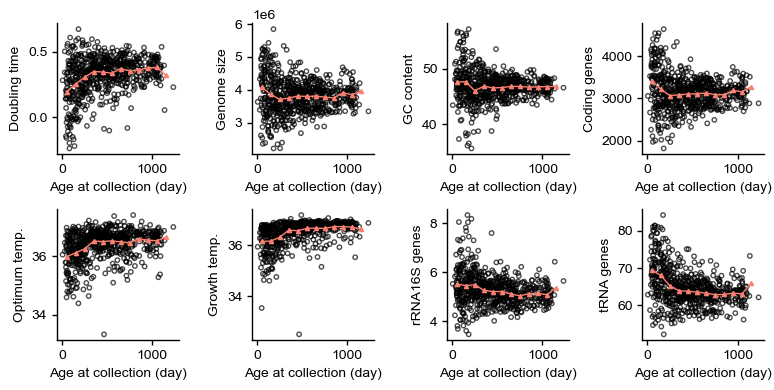

In [94]:
# Plot
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

trait_list = cwn_nt_concat.columns[1:]

col = 4
row = math.ceil(len(trait_list) / col)
fig, axes = plt.subplots(row, col, figsize=(2*col, 2*row))

# nt_pvals = []
for t, ax in zip(trait_list, axes.flatten()):
    x = cwm_nt_metadata["Age_at_Collection"]
    y = cwm_nt_metadata[t]
    ax.scatter(x, y, facecolor="None", edgecolors="black", s=10, alpha=0.7)
    # ax.set_title(t)
    ax.set_xlabel("Age at collection (day)")
    ax.set_ylabel(titles[t])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmean = bin_mid_list
    ymean = cwm_nt_metadata[['cut', t]].groupby(by='cut').mean()
    ax.plot(xmean, ymean, marker='^', linewidth=1, markersize=3, color=cmap2.colors[3])

plt.tight_layout()
plt.savefig("../../data/2024-06-16/prediction_cwm_continuous_all.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

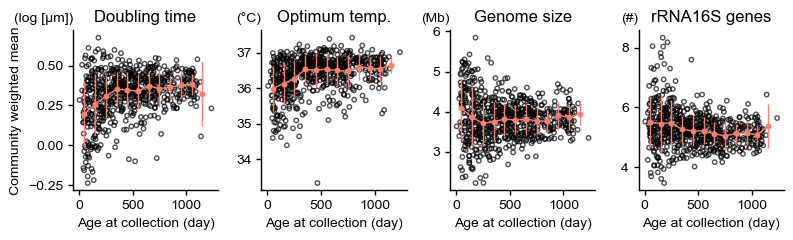

In [95]:
# Plot
mpl.rcParams['axes.xmargin'] = 0.05
mpl.rcParams['axes.ymargin'] = 0.05

# trait_list = ['doubling_h', 'optimum_tmp', 'genome_size', 'gc_content', 'rRNA16S_genes', 'tRNA_genes']
trait_list = ['doubling_h', 'optimum_tmp', 'genome_size', 'rRNA16S_genes']
yunit_dict = {'doubling_h': '(log [µm])', 'optimum_tmp': '(°C)',
              'genome_size': '(Mb)', 'gc_content': '(%)', 'rRNA16S_genes': '(#)', 'tRNA_genes': '(#)'}

col = 4
row = math.ceil(len(trait_list) / col)
fig, axes = plt.subplots(row, col, figsize=(2*col, 2.5*row))

# nt_pvals = []
for t, ax in zip(trait_list, axes.flatten()):
    # sns.regplot(x="Age_at_Collection", y=t, data=cwm_nt_metadata, ax=ax, scatter_kws={'color': 'black', 's': 5}, line_kws={'color': 'red'}, order=3, ci=95)
    x = cwm_nt_metadata["Age_at_Collection"]
    y = cwm_nt_metadata[t]
    if t == 'genome_size':
        y = y / 1e+6
    ax.scatter(x, y, facecolor="None", edgecolors="black", s=10, alpha=0.7)
    ax.set_title(titles[t])
    ax.set_xlabel("Age at collection (day)")
    ax.text(0, 1.05, yunit_dict[t], ha='right', transform=ax.transAxes)
    if t == trait_list[0]:
        ax.set_ylabel("Community weighted mean")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    xmean = bin_mid_list
    ymean = cwm_nt_metadata[['cut', t]].groupby(by='cut').mean()
    yerr = cwm_nt_metadata[['cut', t]].groupby(by='cut').std()
    if t == 'genome_size':
        ymean = ymean / 1e+6
        yerr = yerr / 1e+6
    ax.plot(xmean, ymean, marker='o', linewidth=1, markersize=3, color=cmap2.colors[3])
    ax.errorbar(xmean, ymean[t], yerr = yerr[t],
                capsize=0, fmt='o', markersize=3, elinewidth=1,
                ecolor=cmap2.colors[3], markeredgecolor=cmap2.colors[3], color=cmap2.colors[3])

    # correlation, p_value = pearsonr(cwm_nt_metadata["Age_at_Collection"], cwm_nt_metadata[t])
    # nt_pvals.append(p_value)

plt.tight_layout()
plt.savefig("../../data/2024-06-16/prediction_cwm_continuous_limited.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

### By phylum-level taxonomy

In [96]:
trait_list = ['doubling_h', 'optimum_tmp', 'growth_tmp', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']
yunit_dict = {'doubling_h': '(log [µm])', 'optimum_tmp': '(°C)', 'growth_tmp': '(°C)',
              'genome_size': '(Mb)', 'gc_content': '(%)', 'coding_genes': '(#)',
              'rRNA16S_genes': '(#)', 'tRNA_genes': '(#)'}

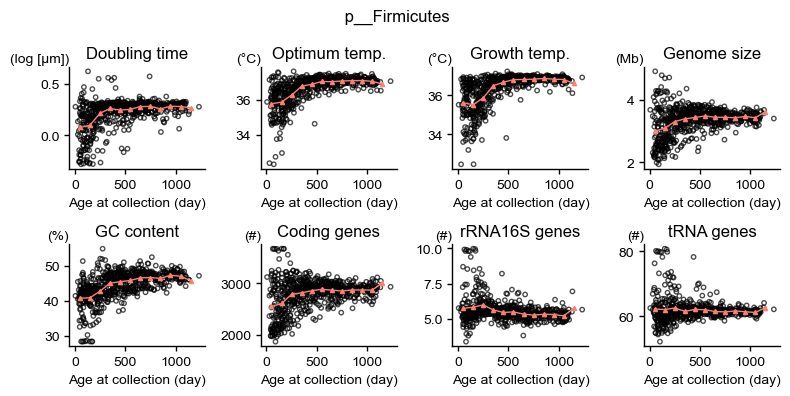

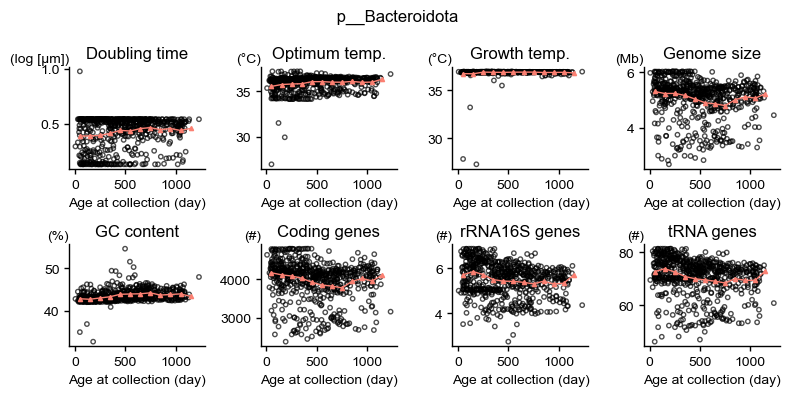

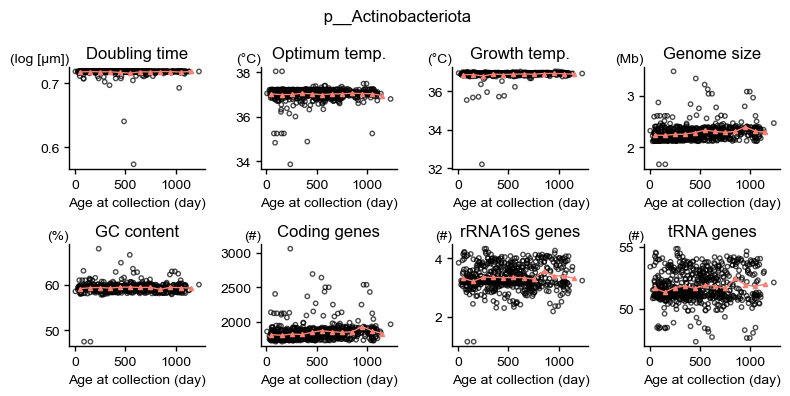

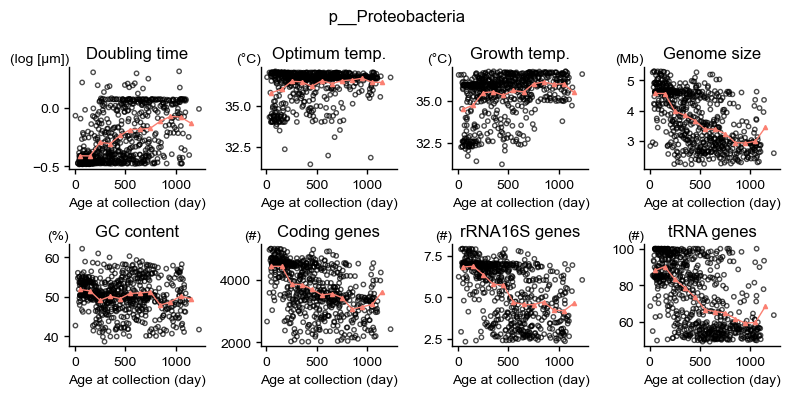

In [97]:
nt = ["doubling_h", "genome_size", "gc_content", "coding_genes", "optimum_tmp", "growth_tmp", "rRNA16S_genes", "tRNA_genes"]

p_list = [' p__Firmicutes', ' p__Bacteroidota', ' p__Actinobacteriota', ' p__Proteobacteria']

def above_abd_thres(df, focal_col, thres_col, thres):
    res = df[focal_col]
    if df[thres_col] < thres:
        res = np.nan
    return res

for p in p_list:

    weighted_nt = dict()
    is_first = True

    for t in nt:
        # filtering
        x = pd.merge(table, pred[["sequence", t+"_nsti"]], how="inner", on="sequence")
        filtered_table = x[x[t+"_nsti"] < threshold_phylodistance.loc[t, "threshold"]].drop(t+"_nsti", axis=1).copy()

        # normalize
        filtered_table = normalize_by_phylum(filtered_table, taxonomy_split, p)
        # melt table
        melt_table = filtered_table.melt(id_vars="sequence", value_name="abundance", var_name="sample")
        # Merging tooks several seconds
        melt_trait = pd.merge(melt_table, pred[["sequence", t]], how="inner", on="sequence")
        melt_trait["weighted_nt"] = melt_trait["abundance"] * melt_trait[t]

        cwm_nt = melt_trait[["sample", "abundance", "weighted_nt"]].groupby(by="sample").sum()
        cwm_nt = cwm_nt.reset_index()
        cwm_nt = cwm_nt.sort_values(by="sample")
        cwm_nt['weighted_nt'] = cwm_nt.apply( # Remove not-annotated samples
            lambda df: above_abd_thres(df, focal_col='weighted_nt', thres_col='abundance', thres=0.01), axis=1)

        if len(list(cwm_nt["weighted_nt"])) == 0:
            continue
        if is_first:
            is_first = False
            weighted_nt["sample"] = list(cwm_nt["sample"])
        weighted_nt[t] = list(cwm_nt["weighted_nt"])

    cwn_nt_concat = pd.DataFrame(weighted_nt)
    cwm_nt_metadata = pd.merge(cwn_nt_concat, metadata, how="inner", left_on="sample", right_on="G_id")

    cwm_nt_metadata["Age_at_Collection"] = cwm_nt_metadata["Age_at_Collection"].astype(int)

    bin_width=100
    bin_max = 1200
    bin_list = list(np.arange(start=0, stop=bin_max+1, step=bin_width))
    bin_mid_list = list(np.arange(start=bin_width/2, stop=bin_max+1, step=bin_width))
    cwm_nt_metadata['cut'] = pd.cut(cwm_nt_metadata['Age_at_Collection'], bins=bin_list)

    # Plot
    mpl.rcParams['axes.xmargin'] = 0.05
    mpl.rcParams['axes.ymargin'] = 0.05

    trait_list = ['doubling_h', 'optimum_tmp', 'growth_tmp', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']
    yunit_dict = {'doubling_h': '(log [µm])', 'optimum_tmp': '(°C)', 'growth_tmp': '(°C)',
                'genome_size': '(Mb)', 'gc_content': '(%)', 'coding_genes': '(#)',
                'rRNA16S_genes': '(#)', 'tRNA_genes': '(#)'}

    col = 4
    row = math.ceil(len(trait_list) / col)
    fig, axes = plt.subplots(row, col, figsize=(2*col, 2*row))

    for t, ax in zip(trait_list, axes.flatten()):
        x = cwm_nt_metadata["Age_at_Collection"]
        y = cwm_nt_metadata[t]
        if t == 'genome_size':
            y = y / 1e+6
        ax.scatter(x, y, facecolor="None", edgecolors="black", s=10, alpha=0.7)
        ax.set_title(titles[t])
        ax.set_xlabel("Age at collection (day)")
        ax.text(0, 1.05, yunit_dict[t], ha='right', transform=ax.transAxes)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        xmean = bin_mid_list
        ymean = cwm_nt_metadata[['cut', t]].groupby(by='cut').mean()
        if t == 'genome_size':
            ymean = ymean / 1e+6
        ax.plot(xmean, ymean, marker='^', linewidth=1, markersize=3, color=cmap2.colors[3])

    fig.suptitle(p)
    plt.tight_layout()

    plt.savefig(f"../../data/2024-06-16/prediction_cwm_continuous_{p}.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

## Categorical traits

### All of microbiome

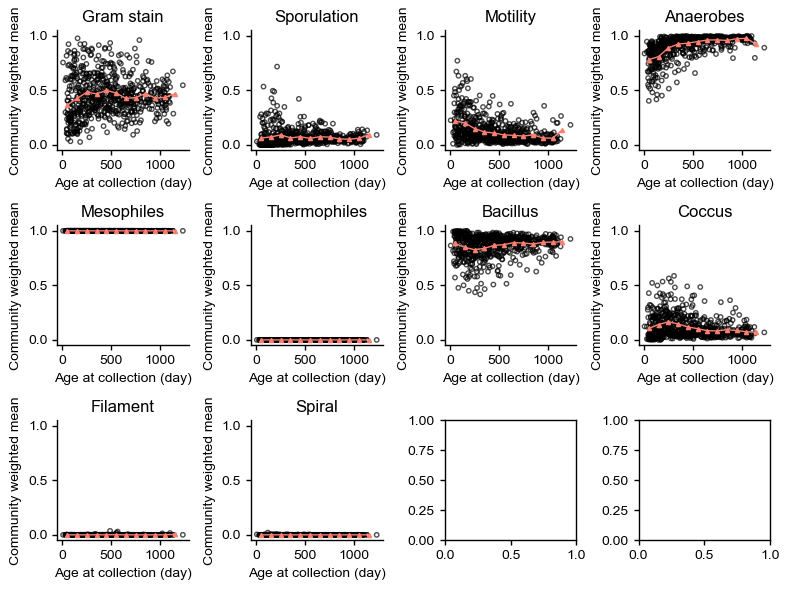

In [98]:
ct = ['gram_stain', 'sporulation', 'motility', 'anaerobic_respiration', 'mesophilic_range_tmp', 'thermophilic_range_tmp', 'bacillus_cell_shape', 'coccus_cell_shape', 'filament_cell_shape', 'spiral_cell_shape']

weighted_ct = dict()
is_first = True

p = None

for t in ct:
    x = pd.merge(table, pred[["sequence", t+"_nsti"]], how="inner", on="sequence")
    filtered_table = x[x[t+"_nsti"] < threshold_phylodistance.loc[t, "threshold"]].drop(t+"_nsti", axis=1).copy()

    # normalize
    # abundance = filtered_table.iloc[:, 1:]
    # filtered_table.iloc[:, 1:] = abundance / abundance.sum(axis=0)
    filtered_table = normalize_by_phylum(filtered_table, taxonomy_split, p)
    # melt table
    melt_table = filtered_table.melt(id_vars="sequence", value_name="abundance", var_name="sample")
    # Merging tooks several seconds
    melt_trait = pd.merge(melt_table, pred[["sequence", t]], how="inner", on="sequence")

    melt_trait["weighted_ct"] = melt_trait["abundance"] * melt_trait[t]

    cwm_ct = melt_trait[["sample", "weighted_ct"]].groupby(by="sample").sum()
    cwm_ct = cwm_ct.reset_index()
    cwm_ct = cwm_ct.sort_values(by="sample")
    if len(list(cwm_ct["weighted_ct"])) == 0:
        continue
    if is_first:
        is_first = False
        weighted_ct["sample"] = list(cwm_ct["sample"])
    weighted_ct[t] = list(cwm_ct["weighted_ct"])

cwn_ct_concat = pd.DataFrame(weighted_ct)
cwm_ct_metadata = pd.merge(cwn_ct_concat, metadata, how="inner", left_on="sample", right_on="G_id")
cwm_ct_metadata["Age_at_Collection"] = cwm_ct_metadata["Age_at_Collection"].astype(int)

bin_width=100
bin_max = 1200
bin_list = list(np.arange(start=0, stop=bin_max+1, step=bin_width))
bin_mid_list = list(np.arange(start=bin_width/2, stop=bin_max+1, step=bin_width))
cwm_ct_metadata['cut'] = pd.cut(cwm_ct_metadata['Age_at_Collection'], bins=bin_list)

# Plot
trait_list = cwn_ct_concat.columns[1:]

col = 4
row = math.ceil(len(trait_list) / col)
fig, axes = plt.subplots(row, col, figsize=(2*col, 2*row))

# ct_pvals = []
for t, ax in zip(trait_list, axes.flatten()):
    ax.scatter(cwm_ct_metadata["Age_at_Collection"], cwm_ct_metadata[t], facecolor="None", edgecolors="black", s=10, alpha=0.7)
    ax.set_title(titles[t])
    ax.set_xlabel("Age at collection (day)")
    ax.set_ylabel("Community weighted mean")
    ax.set_ylim(-0.05, 1.05)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # correlation, p_value = pearsonr(cwm_ct_metadata["Age_at_Collection"], cwm_ct_metadata[t])
    # ct_pvals.append(p_value)
    xmean = bin_mid_list
    ymean = cwm_ct_metadata[['cut', t]].groupby(by='cut').mean()
    ax.plot(xmean, ymean, marker='^', linewidth=1, markersize=3, color=cmap2.colors[3])

plt.tight_layout()
plt.savefig("../../data/2024-06-16/prediction_cwm_categorical_all.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

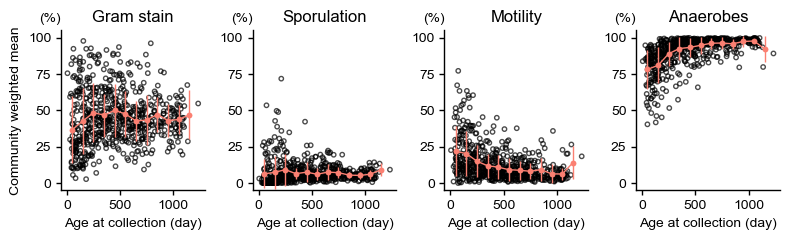

In [99]:
# Plot
trait_list = ['gram_stain', 'sporulation', 'motility', 'anaerobic_respiration']

col = 4
row = math.ceil(len(trait_list) / col)
fig, axes = plt.subplots(row, col, figsize=(2*col, 2.5*row))

# ct_pvals = []
for t, ax in zip(trait_list, axes.flatten()):
    x = cwm_ct_metadata["Age_at_Collection"]
    y = cwm_ct_metadata[t] * 100 # Convert to percent
    ax.scatter(x, y, facecolor="None", edgecolors="black", s=10, alpha=0.7)
    ax.set_title(titles[t])
    ax.set_xlabel("Age at collection (day)")
    if t == trait_list[0]:
        ax.set_ylabel("Community weighted mean")
    ax.set_ylim(-5, 105)
    ax.text(0, 1.05, '(%)', ha='right', transform=ax.transAxes)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # correlation, p_value = pearsonr(cwm_ct_metadata["Age_at_Collection"], cwm_ct_metadata[t])
    # ct_pvals.append(p_value)
    xmean = bin_mid_list
    ymean = cwm_ct_metadata[['cut', t]].groupby(by='cut').mean() * 100 # Convert to percent
    yerr = cwm_ct_metadata[['cut', t]].groupby(by='cut').std() * 100
    ax.plot(xmean, ymean, marker='o', linewidth=1, markersize=3, color=cmap2.colors[3])
    ax.errorbar(xmean, ymean[t], yerr = yerr[t],
                capsize=0, fmt='o', markersize=3, elinewidth=1,
                ecolor=cmap2.colors[3], markeredgecolor=cmap2.colors[3], color=cmap2.colors[3])

plt.tight_layout()
plt.savefig("../../data/2024-06-16/prediction_cwm_categorical_limited.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

### By phylum-level taxonomy

In [100]:
def above_abd_thres(df, focal_col, thres_col, thres):
    res = df[focal_col]
    if df[col] < thres:
        res = np.nan
    return res

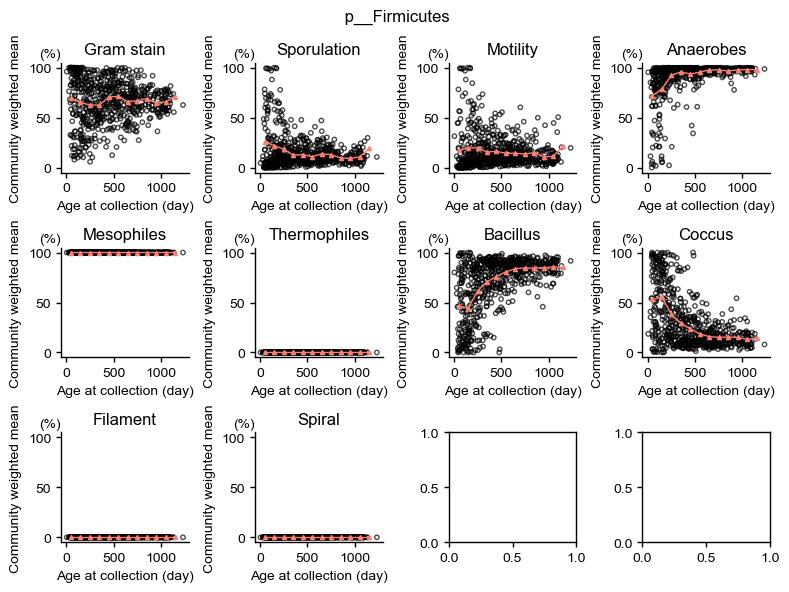

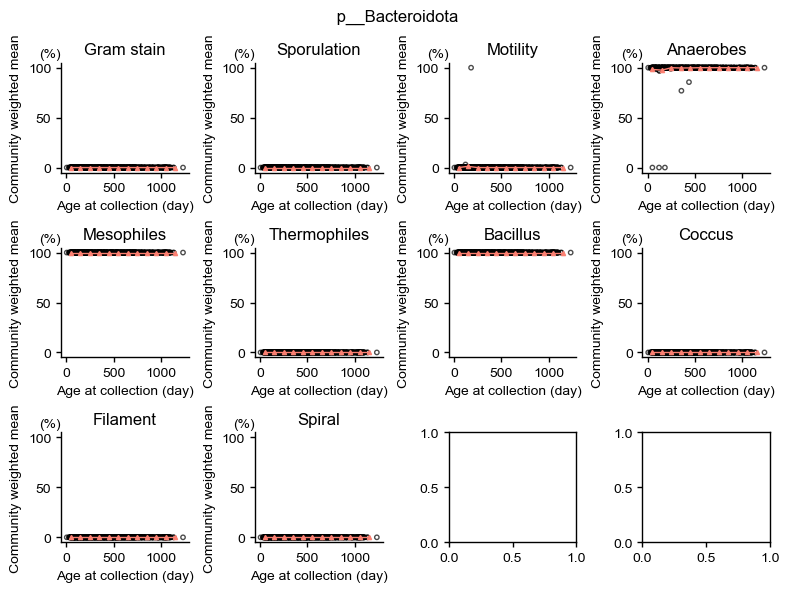

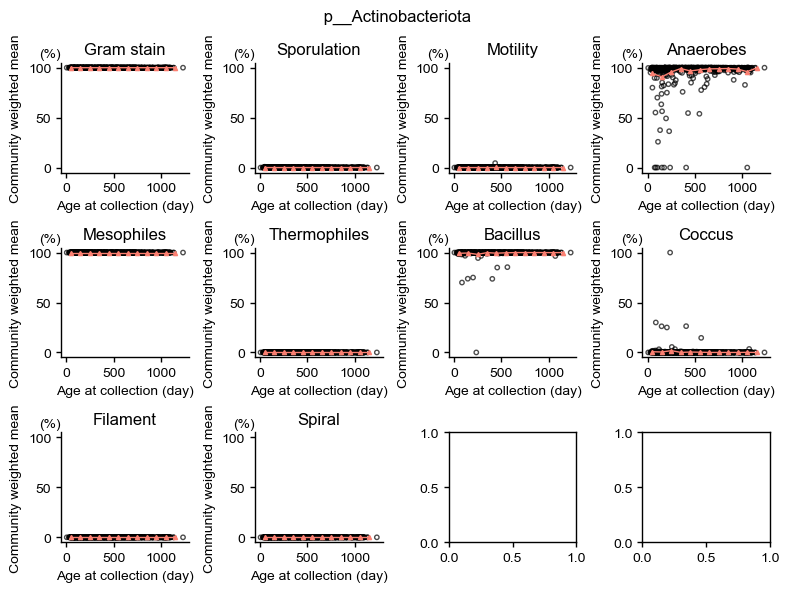

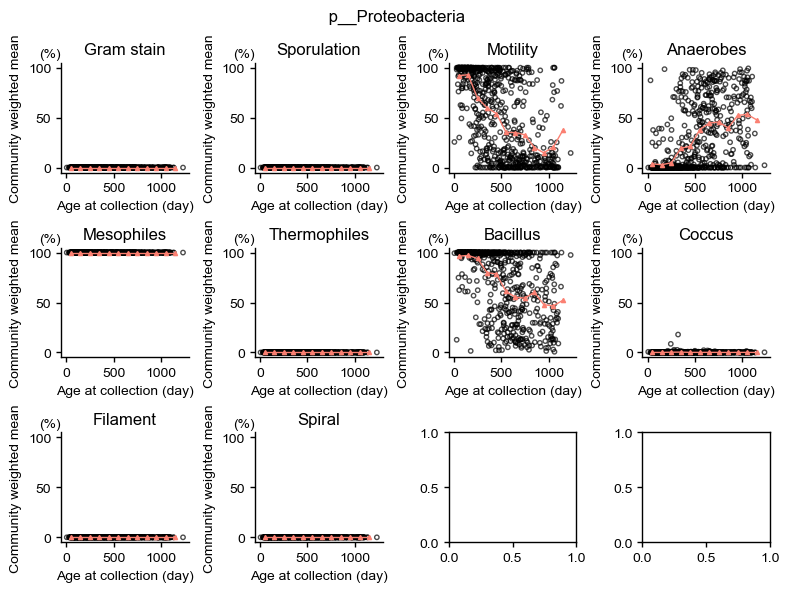

In [101]:
ct = ['gram_stain', 'sporulation', 'motility', 'anaerobic_respiration', 'mesophilic_range_tmp', 'thermophilic_range_tmp', 'bacillus_cell_shape', 'coccus_cell_shape', 'filament_cell_shape', 'spiral_cell_shape']

p_list = [' p__Firmicutes', ' p__Bacteroidota', ' p__Actinobacteriota', ' p__Proteobacteria']

def above_abd_thres(df, focal_col, thres_col, thres):
    res = df[focal_col]
    if df[thres_col] < thres:
        res = np.nan
    return res

for p in p_list:
    weighted_ct = dict()
    is_first = True

    for t in ct:
        x = pd.merge(table, pred[["sequence", t+"_nsti"]], how="inner", on="sequence")
        filtered_table = x[x[t+"_nsti"] < threshold_phylodistance.loc[t, "threshold"]].drop(t+"_nsti", axis=1).copy()

        # normalize
        # abundance = filtered_table.iloc[:, 1:]
        # filtered_table.iloc[:, 1:] = abundance / abundance.sum(axis=0)
        filtered_table = normalize_by_phylum(filtered_table, taxonomy_split, p)
        # melt table
        melt_table = filtered_table.melt(id_vars="sequence", value_name="abundance", var_name="sample")
        # Merging tooks several seconds
        melt_trait = pd.merge(melt_table, pred[["sequence", t]], how="inner", on="sequence")
        # if melt_trait["abundance"].sum() < 0.001:
        #     continue
        melt_trait["weighted_ct"] = melt_trait["abundance"] * melt_trait[t]

        cwm_ct = melt_trait[["sample", "abundance", "weighted_ct"]].groupby(by="sample").sum()
        cwm_ct = cwm_ct.reset_index()
        cwm_ct['weighted_ct'] = cwm_ct.apply(
            lambda df: above_abd_thres(df, focal_col='weighted_ct', thres_col='abundance', thres=0.01), axis=1)
        cwm_ct = cwm_ct.sort_values(by="sample")
        if len(list(cwm_ct["weighted_ct"])) == 0:
            continue
        if is_first:
            is_first = False
            weighted_ct["sample"] = list(cwm_ct["sample"])
        weighted_ct[t] = list(cwm_ct["weighted_ct"])

    cwn_ct_concat = pd.DataFrame(weighted_ct)
    cwm_ct_metadata = pd.merge(cwn_ct_concat, metadata, how="inner", left_on="sample", right_on="G_id")

    cwm_ct_metadata["Age_at_Collection"] = cwm_ct_metadata["Age_at_Collection"].astype(int)
    bin_width=100
    bin_max = 1200
    bin_list = list(np.arange(start=0, stop=bin_max+1, step=bin_width))
    bin_mid_list = list(np.arange(start=bin_width/2, stop=bin_max+1, step=bin_width))
    cwm_ct_metadata['cut'] = pd.cut(cwm_ct_metadata['Age_at_Collection'], bins=bin_list)

    # Plot
    trait_list = cwn_ct_concat.columns[1:]

    col = 4
    row = math.ceil(len(trait_list) / col)
    fig, axes = plt.subplots(row, col, figsize=(2*col, 2*row))

    # ct_pvals = []
    for t, ax in zip(trait_list, axes.flatten()):
        x = cwm_ct_metadata["Age_at_Collection"]
        y = cwm_ct_metadata[t] * 100 # Convert to percent
        ax.scatter(x, y, facecolor="None", edgecolors="black", s=10, alpha=0.7)
        ax.set_title(titles[t])
        ax.set_xlabel("Age at collection (day)")
        ax.set_ylabel("Community weighted mean")
        ax.text(0, 1.05, '(%)', ha='right', transform=ax.transAxes)
        ax.set_ylim(-5, 105)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        xmean = bin_mid_list
        ymean = cwm_ct_metadata[['cut', t]].groupby(by='cut').mean() * 100 # Convert to percent
        ax.plot(xmean, ymean, marker='^', linewidth=1, markersize=3, color=cmap2.colors[3])

    fig.suptitle(p)
    plt.tight_layout()
    plt.savefig(f"../../data/2024-06-16/prediction_cwm_categorical_{p}.pdf", format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)